In [6]:
# Install necessary libraries
!pip install snntorch brevitas onnxoptimizer netron --quiet

!pip install onnxruntime --quiet
!pip install onnxoptimizer --quiet

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import snntorch.functional as SF
import snntorch as snn
import matplotlib.pyplot as plt
import brevitas.nn as qnn
from torch.nn import Module
from brevitas.quant import Int32Bias
import onnx
import onnxruntime
import onnxoptimizer
import netron

# Check if GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

batch_size = 128

transform = transforms.Compose([
            transforms.Resize((27, 27)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))
            ])

data_path = "/kaggle/working/mnist"  # Change to writable directory

mnist_train = datasets.MNIST(root=data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root=data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

# Display a sample image
# image, label = next(iter(train_loader))
# plt.imshow(image[0].squeeze(), cmap='gray')
# plt.title(f"Label: {label[0]}")
# plt.show()

In [11]:
from snntorch import surrogate
from snntorch import utils
from brevitas.quant.scaled_int import Int8ActPerTensorFloat

beta = 1  # Neuron decay rate
spike_grad = surrogate.fast_sigmoid()

class QuantWeightLeNet(Module):
    def __init__(self):
        super(QuantWeightLeNet, self).__init__()
        self.quant_inp = qnn.QuantIdentity(bit_width=8, return_quant_tensor=True)
        self.conv1 = qnn.QuantConv2d(1, 32, 3 ,bias=True, input_quant=Int8ActPerTensorFloat, weight_bit_width=8, bias_quant=Int32Bias)
        self.lif1  = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, reset_mechanism="zero")

        self.conv2 = qnn.QuantConv2d(32, 32, 3, bias=True, input_quant=Int8ActPerTensorFloat, weight_bit_width=8, bias_quant=Int32Bias)
        self.lif2  = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, reset_mechanism="zero")
        
        self.conv3 = qnn.QuantConv2d(32, 10, 3, bias=True, input_quant=Int8ActPerTensorFloat, weight_bit_width=8, bias_quant=Int32Bias)
        self.lif3  = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, reset_mechanism="zero")
        
        self.fc1   = qnn.QuantLinear(10*21*21, 10, bias=True, input_quant=Int8ActPerTensorFloat, weight_bit_width=8, bias_quant=Int32Bias)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, reset_mechanism="zero")

    def forward(self, x, num_steps):
        utils.reset(self)
        spk_rec = []
        for step in range(num_steps):
            bin_image = (x > (0.5 - (.05 * step))).float()
            out = self.quant_inp(x)
            out = self.lif1(self.conv1(out))
            out = self.lif2(self.conv2(out))
            out = self.lif3(self.conv3(out))
            out = out.reshape(out.shape[0], -1)
            out = self.fc1(out)
            spk_out, mem_out = self.lif_out(out)
            spk_rec.append(spk_out)
        return torch.stack(spk_rec)

# Instantiate model
model = QuantWeightLeNet().to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

num_epochs = 4
num_steps = 5

loss_hist = []
acc_hist = []

In [13]:
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        model.train()

        # Forward pass
        spk_rec = model(data, num_steps)

        # Compute loss
        loss = loss_fn(spk_rec, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss.item())

        if i % 50 == 0:
            acc = SF.accuracy_rate(spk_rec, targets) * 100
            print(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item():.6f}, Accuracy: {acc:.2f}%")
            acc_hist.append(acc)

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1488: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1928.)
  return super().rename(names)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:311.)
  return F.conv2d(


Epoch 0, Iteration 0, Loss: 0.500000, Accuracy: 17.97%
Epoch 0, Iteration 50, Loss: 0.115781, Accuracy: 64.06%
Epoch 0, Iteration 100, Loss: 0.092031, Accuracy: 75.00%
Epoch 0, Iteration 150, Loss: 0.081719, Accuracy: 78.12%
Epoch 0, Iteration 200, Loss: 0.065312, Accuracy: 77.34%
Epoch 0, Iteration 250, Loss: 0.057813, Accuracy: 85.16%
Epoch 0, Iteration 300, Loss: 0.057969, Accuracy: 84.38%
Epoch 0, Iteration 350, Loss: 0.043594, Accuracy: 89.06%
Epoch 0, Iteration 400, Loss: 0.040469, Accuracy: 94.53%
Epoch 0, Iteration 450, Loss: 0.040938, Accuracy: 87.50%
Epoch 1, Iteration 0, Loss: 0.042656, Accuracy: 87.50%
Epoch 1, Iteration 50, Loss: 0.036875, Accuracy: 89.84%
Epoch 1, Iteration 100, Loss: 0.037344, Accuracy: 89.06%
Epoch 1, Iteration 150, Loss: 0.050938, Accuracy: 85.16%
Epoch 1, Iteration 200, Loss: 0.025000, Accuracy: 94.53%
Epoch 1, Iteration 250, Loss: 0.032344, Accuracy: 95.31%
Epoch 1, Iteration 300, Loss: 0.022656, Accuracy: 97.66%
Epoch 1, Iteration 350, Loss: 0.03531

In [14]:
from brevitas.export import export_onnx_qcdq

model1 = model.to("cpu")
args1 = (torch.randn(1, 1, 27, 27), 5)
export_path = "brevitas_bias_quant_paper.onnx"

export_onnx_qcdq(model1, args=args1, export_path=export_path)
print(f"Model exported to {export_path}")

# Verify ONNX Export
onnx_model = onnx.load(export_path)
onnx.checker.check_model(onnx_model)
print("ONNX model is valid")

/usr/local/lib/python3.10/dist-packages/brevitas/export/onnx/standard/manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


Model exported to brevitas_bias_quant_paper.onnx
ONNX model is valid


In [15]:
int_weight = model.conv1.quant_weight().int()
zero_point = model.conv1.weight_quant.zero_point()
scale = model.conv1.weight_quant.scale()

quant_weight_manually = (int_weight - zero_point) * scale

assert model.conv1.quant_weight().value.isclose(quant_weight_manually).all().item()
print("Quantization validated successfully")

Quantization validated successfully


spk1:
  Channel 0: 9.31% spiking

spk2:
  Channel 0: 1.26% spiking

spk3:
  Channel 0: 0.00% spiking



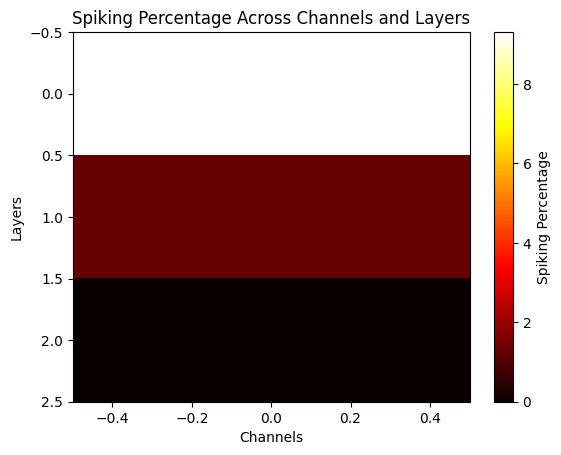

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from snntorch import utils

# Example model
model = QuantWeightLeNet().to(device)

def compute_spiking_percentage_per_channel(model, data, num_steps=10):
    utils.reset(model)  # Reset hidden states
    spiking_counts = {"spk1": [], "spk2": [], "spk3": []}
    
    for step in range(num_steps):
        out = model.quant_inp(data)
        spk1 = model.lif1(model.conv1(out))
        spk2 = model.lif2(model.conv2(spk1))
        spk3 = model.lif3(model.conv3(spk2))
        
        # Ensure correct reshaping before fc1
        out = spk3.view(spk3.shape[0], -1)  # Flatten while preserving batch dimension
        expected_fc1_input_size = model.fc1.in_features
        out = out[:, :expected_fc1_input_size]  # Ensure correct size
        
        spk_out, _ = model.lif_out(model.fc1(out))
        
        spiking_counts["spk1"].append(spk1.detach().cpu().numpy())
        spiking_counts["spk2"].append(spk2.detach().cpu().numpy())
        spiking_counts["spk3"].append(spk3.detach().cpu().numpy())
    
    spiking_percentages = {}
    for key in spiking_counts:
        spiking_counts[key] = np.array(spiking_counts[key])  # Convert to NumPy array
        spiking_percentages[key] = np.mean(spiking_counts[key], axis=(0, 2, 3, 4)) * 100  # Average across time, batch, height, width
    
    return spiking_percentages

# Generate dummy input
data = torch.rand((1, 1, 28, 28), device=device)  # Example batch size of 1, single-channel input
spiking_percentages = compute_spiking_percentage_per_channel(model, data)

# Print results
for layer_name, percentages in spiking_percentages.items():
    print(f"{layer_name}:")
    for channel_idx, percentage in enumerate(percentages):
        print(f"  Channel {channel_idx}: {percentage:.2f}% spiking")
    print()

# Visualization
fig, ax = plt.subplots()
cax = ax.imshow(np.array(list(spiking_percentages.values())), cmap='hot', interpolation='nearest', aspect='auto')
ax.set_title("Spiking Percentage Across Channels and Layers")
ax.set_xlabel("Channels")
ax.set_ylabel("Layers")
plt.colorbar(cax, label='Spiking Percentage')
plt.show()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 45.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.17MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.10MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

spk1:
  Channel 0: 5.48% spiking
  Channel 1: 11.22% spiking
  Channel 2: 0.34% spiking
  Channel 3: 2.82% spiking
  Channel 4: 22.87% spiking
  Channel 5: 14.32% spiking
  Channel 6: 3.38% spiking
  Channel 7: 15.77% spiking
  Channel 8: 1.12% spiking
  Channel 9: 3.54% spiking
  Channel 10: 14.41% spiking
  Channel 11: 5.34% spiking
  Channel 12: 8.48% spiking
  Channel 13: 1.59% spiking
  Channel 14: 7.66% spiking
  Channel 15: 9.24% spiking
  Channel 16: 17.15% spiking
  Channel 17: 4.14% spiking
  Channel 18: 0.01% spiking
  Channel 19: 23.92% spiking
  Channel 20: 0.00% spiking
  Channel 21: 18.49% spiking
  Channel 22: 0.00% spiking
  Channel 23: 14.14% spiking
  Channel 24: 18.64% spiking
  Channel 25: 0.57% spiking
  Channel 26: 2.54% spiking
  Channel 27: 0.25% spiking
  Channel 28: 16.25% spiking
  Channel 29: 0.01% spiking
  Channel 30: 7.92% spiking
  Channel 31: 16.74% spiking

spk2:
  Channel 0: 2

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

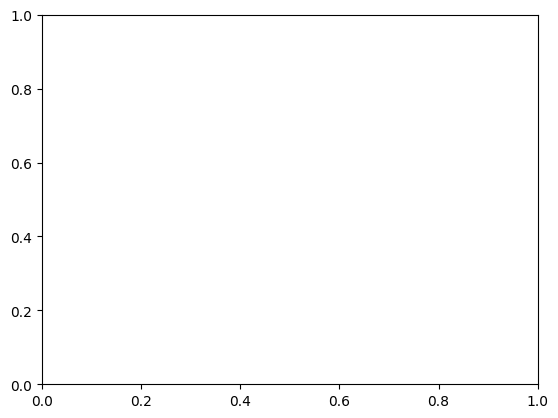

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from snntorch import utils
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Example model
model = QuantWeightLeNet().to(device)

# Load MNIST dataset
test_loader = DataLoader(
    datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor()),
    batch_size=1, shuffle=False
)

def compute_spiking_percentage_per_channel(model, dataloader, num_steps=10):
    spiking_sums = {"spk1": None, "spk2": None, "spk3": None}
    total_samples = 0
    
    for data, _ in dataloader:
        data = data.to(device)
        utils.reset(model)  # Reset hidden states
        spiking_counts = {"spk1": [], "spk2": [], "spk3": []}
        
        for step in range(num_steps):
            out = model.quant_inp(data)
            spk1 = model.lif1(model.conv1(out))
            spk2 = model.lif2(model.conv2(spk1))
            spk3 = model.lif3(model.conv3(spk2))
            
            # Ensure correct reshaping before fc1
            out = spk3.view(spk3.shape[0], -1)  # Flatten while preserving batch dimension
            expected_fc1_input_size = model.fc1.in_features
            out = out[:, :expected_fc1_input_size]  # Ensure correct size
            
            spk_out, _ = model.lif_out(model.fc1(out))
            
            spiking_counts["spk1"].append(spk1.detach().cpu().numpy())
            spiking_counts["spk2"].append(spk2.detach().cpu().numpy())
            spiking_counts["spk3"].append(spk3.detach().cpu().numpy())
        
        for key in spiking_counts:
            spiking_counts[key] = np.array(spiking_counts[key])  # Convert to NumPy array
            mean_spikes = np.mean(spiking_counts[key], axis=(0, 1, 3, 4))  # Average across time, batch, height, width
            
            if spiking_sums[key] is None:
                spiking_sums[key] = mean_spikes
            else:
                spiking_sums[key] += mean_spikes
        
        total_samples += 1
        if total_samples >= 10000:
            break
    
    spiking_percentages = {key: (spiking_sums[key] / total_samples) * 100 for key in spiking_sums}
    return spiking_percentages

# Compute spiking percentage across 10,000 MNIST samples
spiking_percentages = compute_spiking_percentage_per_channel(model, test_loader)

# Print results
for layer_name, percentages in spiking_percentages.items():
    print(f"{layer_name}:")
    for channel_idx, percentage in enumerate(percentages):
        print(f"  Channel {channel_idx}: {percentage:.2f}% spiking")
    print()

# Visualization
fig, ax = plt.subplots()
cax = ax.imshow(np.array(list(spiking_percentages.values())), cmap='hot', interpolation='nearest', aspect='auto')
ax.set_title("Spiking Percentage Across Channels and Layers")
ax.set_xlabel("Channels")
ax.set_ylabel("Layers")
plt.colorbar(cax, label='Spiking Percentage')
plt.show()

# CHECK SPIKE SPARSITY

In [17]:
class QuantWeightLeNetWithSparsityTracking(Module):
    def __init__(self):
        super(QuantWeightLeNetWithSparsityTracking, self).__init__()
        self.quant_inp = qnn.QuantIdentity(bit_width=8, return_quant_tensor=True)
        self.conv1 = qnn.QuantConv2d(1, 32, 3, bias=True, input_quant=Int8ActPerTensorFloat, weight_bit_width=8, bias_quant=Int32Bias)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, reset_mechanism="zero")
        
        self.conv2 = qnn.QuantConv2d(32, 32, 3, bias=True, input_quant=Int8ActPerTensorFloat, weight_bit_width=8, bias_quant=Int32Bias)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, reset_mechanism="zero")
        
        self.conv3 = qnn.QuantConv2d(32, 10, 3, bias=True, input_quant=Int8ActPerTensorFloat, weight_bit_width=8, bias_quant=Int32Bias)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, reset_mechanism="zero")
        
        self.fc1 = qnn.QuantLinear(10*21*21, 10, bias=True, input_quant=Int8ActPerTensorFloat, weight_bit_width=8, bias_quant=Int32Bias)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, reset_mechanism="zero")
        
        # For storing spikes
        self.spike_records = {}

    def forward(self, x, num_steps):
        utils.reset(self)
        spk_rec = []
        
        # Clear previous spike records
        self.spike_records = {
            'lif1': [], 'lif2': [], 'lif3': [], 'lif_out': []
        }
        
        for step in range(num_steps):
            bin_image = (x > (0.5 - (.05 * step))).float()
            out = self.quant_inp(x)
            
            # First layer
            out = self.conv1(out)
            out, _ = self.lif1(out)  # Get spikes only
            self.spike_records['lif1'].append(out.detach().clone())
            
            # Second layer
            out = self.conv2(out)
            out, _ = self.lif2(out)
            self.spike_records['lif2'].append(out.detach().clone())
            
            # Third layer
            out = self.conv3(out)
            out, _ = self.lif3(out)
            self.spike_records['lif3'].append(out.detach().clone())
            
            # Fully connected layer
            out = out.reshape(out.shape[0], -1)
            out = self.fc1(out)
            spk_out, mem_out = self.lif_out(out)
            self.spike_records['lif_out'].append(spk_out.detach().clone())
            spk_rec.append(spk_out)
            
        return torch.stack(spk_rec)

In [18]:
def calculate_spike_sparsity(model, data_loader, num_steps=5, num_batches=10, device='cpu'):
    """
    Calculate spike sparsity for each channel in each layer.
    
    Args:
        model: QuantWeightLeNetWithSparsityTracking model
        data_loader: DataLoader for input data
        num_steps: Number of time steps for SNN
        num_batches: Number of batches to process
        device: Device to run calculations on
    
    Returns:
        Dictionary containing sparsity metrics for each layer
    """
    model.eval()
    sparsity_stats = {
        'lif1': [], 'lif2': [], 'lif3': [], 'lif_out': []
    }
    
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            if batch_idx >= num_batches:
                break
                
            data = data.to(device)
            model = model.to(device)
            
            # Forward pass to collect spike records
            _ = model(data, num_steps)
            
            # Calculate sparsity for each layer
            for layer_name, spike_records in model.spike_records.items():
                # Stack time steps
                spikes = torch.stack(spike_records)
                
                # Calculate sparsity per channel
                if layer_name in ['lif1', 'lif2', 'lif3']:
                    # For convolutional layers
                    batch_size, channels = spikes.shape[1], spikes.shape[2]
                    total_elements = num_steps * batch_size * spikes.shape[3] * spikes.shape[4]
                    
                    channel_sparsity = []
                    for channel in range(channels):
                        channel_spikes = spikes[:, :, channel, :, :]
                        active_count = torch.sum(channel_spikes).item()
                        sparsity = 1.0 - (active_count / total_elements)
                        channel_sparsity.append(sparsity)
                    
                    sparsity_stats[layer_name].append(channel_sparsity)
                else:
                    # For fully connected layer
                    batch_size, output_size = spikes.shape[1], spikes.shape[2]
                    total_elements = num_steps * batch_size
                    
                    neuron_sparsity = []
                    for neuron in range(output_size):
                        neuron_spikes = spikes[:, :, neuron]
                        active_count = torch.sum(neuron_spikes).item()
                        sparsity = 1.0 - (active_count / total_elements)
                        neuron_sparsity.append(sparsity)
                    
                    sparsity_stats[layer_name].append(neuron_sparsity)
    
    # Average sparsity across batches
    for layer_name in sparsity_stats:
        if sparsity_stats[layer_name]:
            sparsity_stats[layer_name] = torch.tensor(sparsity_stats[layer_name]).mean(dim=0).tolist()
    
    return sparsity_stats

In [19]:
def visualize_spike_sparsity(sparsity_stats):
    """
    Visualize spike sparsity for each layer and channel.
    
    Args:
        sparsity_stats: Dictionary containing sparsity metrics
    """
    plt.figure(figsize=(15, 10))
    
    # Plot for each layer
    for i, (layer_name, sparsity) in enumerate(sparsity_stats.items()):
        plt.subplot(2, 2, i+1)
        
        # Plot channel-wise sparsity
        x = range(len(sparsity))
        plt.bar(x, sparsity)
        
        plt.title(f'Spike Sparsity - {layer_name}')
        plt.xlabel('Channel/Neuron Index')
        plt.ylabel('Sparsity (1 - Activity Ratio)')
        
        # Show average sparsity
        avg_sparsity = sum(sparsity) / len(sparsity)
        plt.axhline(y=avg_sparsity, color='r', linestyle='--', 
                   label=f'Avg: {avg_sparsity:.3f}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate overall sparsity
    all_sparsity = []
    for sparsity in sparsity_stats.values():
        all_sparsity.extend(sparsity)
    
    overall_sparsity = sum(all_sparsity) / len(all_sparsity)
    print(f"Overall network spike sparsity: {overall_sparsity:.4f}")
    
    return overall_sparsity

In [20]:
# Create the tracking version of the model
tracking_model = QuantWeightLeNetWithSparsityTracking()

# Load the trained weights if you have a trained model
if 'model' in globals() and hasattr(model, 'state_dict'):
    tracking_model.load_state_dict(model.state_dict())

# Calculate spike sparsity
sparsity_stats = calculate_spike_sparsity(
    tracking_model, 
    test_loader,  # Use test_loader to evaluate on test data
    num_steps=5,  # Same as in training
    num_batches=10,  # Adjust based on your computational resources
    device=device
)

# Visualize the results
overall_sparsity = visualize_spike_sparsity(sparsity_stats)

# Save the sparsity statistics
import json
with open('spike_sparsity_stats.json', 'w') as f:
    json.dump(sparsity_stats, f)

ValueError: too many values to unpack (expected 2)